<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## LSTM Bot QA

### Datos
El objecto es utilizar datos disponibles de convai de conversaciones en ingleś. Se construirá un BOT para responder a preguntas del usuario (QA).\
[LINK](http://convai.io/data/)

In [1]:
!pip install --upgrade --no-cache-dir gdown --quiet

#### Importamos las librerias necesarias

In [2]:
import re

import numpy as np
import pandas as pd

import os
import gdown

import keras
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM, SimpleRNN
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate
from keras.layers import Bidirectional

from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical

import logging
import os
from pathlib import Path
from io import StringIO
import pickle

from keras.models import Model
from keras.layers import Input, LSTM, Dense
from keras.utils.vis_utils import plot_model

import matplotlib.pyplot as plt
import seaborn as sns

#### Descargamos el dataset

In [3]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('data_volunteers.json', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1QPYxMTBSGNmbyGhknznuO3YWLBOJnhUQ&export=download'
    output = 'data_volunteers.json'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [4]:
# dataset_file
import json

text_file = "data_volunteers.json"
with open(text_file) as f:
    data = json.load(f)



In [5]:
# Observar los campos disponibles en cada linea del dataset
data[0].keys()

dict_keys(['dialog', 'start_time', 'end_time', 'bot_profile', 'user_profile', 'eval_score', 'profile_match', 'participant1_id', 'participant2_id'])

#### Generamos las oraciones de entrada y de salida

In [6]:
chat_in = []
chat_out = []

input_sentences = []
output_sentences = []
output_sentences_inputs = []
max_len = 30

def clean_text(txt):
    txt = txt.lower()    
    txt.replace("\'d", " had")
    txt.replace("\'s", " is")
    txt.replace("\'m", " am")
    txt.replace("don't", "do not")
    txt = re.sub(r'\W+', ' ', txt)
    
    return txt

for line in data:
    for i in range(len(line['dialog'])-1):
        chat_in = clean_text(line['dialog'][i]['text'])
        chat_out = clean_text(line['dialog'][i+1]['text'])

        if len(chat_in) >= max_len or len(chat_out) >= max_len:
            continue

        input_sentence, output = chat_in, chat_out
        
        # output sentence (decoder_output) tiene <eos>
        output_sentence = output + ' <eos>'
        # output sentence input (decoder_input) tiene <sos>
        output_sentence_input = '<sos> ' + output

        input_sentences.append(input_sentence)
        output_sentences.append(output_sentence)
        output_sentences_inputs.append(output_sentence_input)

print("Cantidad de rows utilizadas:", len(input_sentences))

Cantidad de rows utilizadas: 6033


In [7]:
input_sentences[1], output_sentences[1], output_sentences_inputs[1]

('hi how are you ', 'not bad and you  <eos>', '<sos> not bad and you ')

### 2 - Preprocesamiento
Realizar el preprocesamiento necesario para obtener:
- word2idx_inputs, max_input_len
- word2idx_outputs, max_out_len, num_words_output
- encoder_input_sequences, decoder_output_sequences, decoder_targets

#### Definir el tamaño máximo del vocabulario


In [8]:
MAX_VOCAB_SIZE = 9000

#### Tokenizamos con el tokenizador de Keras el vector de palabras de entrada

In [9]:
input_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)

word2idx_inputs = input_tokenizer.word_index
print("Palabras en el vocabulario de palabras de entrada:", len(word2idx_inputs))

max_input_len = max(len(sen) for sen in input_integer_seq)
print("Sentencia de entrada más larga:", max_input_len)

Palabras en el vocabulario de palabras de entrada: 1799
Sentencia de entrada más larga: 9


#### Tokenizamos con el tokenizador de Keras el vector de palabras de salida

In [10]:
#DAdo que la salida esta también en ingles no necesito filtrar ningun caracter especial. Si debo evitar los caracteres < y >
output_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE,filters='!"#$%&()*+,-./:;=¿?@[\\]^_`{|}~\t\n')
#Sumo los simbolos de SOS y EOS a los textos del tokenizador. El EOS ya forma parte del vector de output_sentences
output_tokenizer.fit_on_texts(["<sos>", "<eos>"] + output_sentences)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

word2idx_outputs = output_tokenizer.word_index
print("Palabras en el vocabulario de palabras de salida:", len(word2idx_outputs))

num_words_output = min(len(word2idx_outputs) + 1, MAX_VOCAB_SIZE) # Se suma 1 por el primer <sos>
max_out_len = max(len(sen) for sen in output_integer_seq)
print("Sentencia de salida más larga:", max_out_len)

Palabras en el vocabulario de palabras de salida: 1806
Sentencia de salida más larga: 10


Tendremos para la entrada de la capa de encoding un maximo de 9 palabras, y para la layer del elemento anterior un maximo de 10 palabras

#### Hacemos el padding de las oraciones

In [11]:
print("Cantidad de rows del dataset:", len(input_integer_seq))

#En encoder padding va al principio
encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences shape:", encoder_input_sequences.shape)

#En decoder padding va al final porque al principio esta el EOS
decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_input_sequences shape:", decoder_input_sequences.shape)

Cantidad de rows del dataset: 6033
encoder_input_sequences shape: (6033, 9)
decoder_input_sequences shape: (6033, 10)


#### Ajustamos el vector de salida como un oneHotEncoding

In [12]:
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
decoder_targets = to_categorical(decoder_output_sequences, num_classes=num_words_output)
decoder_targets.shape

(6033, 10, 1807)

### 3 - Preparar los embeddings
Utilizar los embeddings de Glove o FastText para transformar los tokens de entrada en vectores

#### Descargamos los embedding de fasttex para utilizar en nuestro modelo

In [13]:
if os.access('fasttext.pkl', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1KU5qmAYh3LATMvVgocFDfW-PK3prm1WU&export=download'
    output = 'fasttext.pkl'
    gdown.download(url, output, quiet=False)
else:
    print("Los embeddings fasttext.pkl ya están descargados")

Los embeddings fasttext.pkl ya están descargados


#### Generamos la funcion para leer los embeddings

In [14]:
class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60


class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

#### Generamos la matriz de embeddings

In [15]:
model_embeddings = FasttextEmbeddings()

In [16]:
print('Preparando matriz de embeddings...')
embed_dim = model_embeddings.N_FEATURES
words_not_found = []

# word_index provieen del tokenizer

nb_words = min(MAX_VOCAB_SIZE, len(word2idx_inputs)) # vocab_size
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word2idx_inputs.items():
    if i >= nb_words:
        continue
    embedding_vector = model_embeddings.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        
        embedding_matrix[i] = embedding_vector
    else:
        # words not found in embedding index will be all-zeros.
        words_not_found.append(word)

print('Numero de word embeddings nulos:', np.sum(np.sum(embedding_matrix, axis=1) == 0))

Preparando matriz de embeddings...
Numero de word embeddings nulos: 1


In [17]:
print("Shape de la matriz de embeddings: ", embedding_matrix.shape)

Shape de la matriz de embeddings:  (1799, 300)


### 4 - Entrenar el modelo
Entrenar un modelo basado en el esquema encoder-decoder utilizando los datos generados en los puntos anteriores. Utilce como referencias los ejemplos vistos en clase.

#### Definimos el modelo de nuestra red

In [18]:
n_units = 160

# define training encoder
encoder_inputs = Input(shape=(max_input_len))

#Capa de embeddings
encoder_embedding_layer = Embedding(
          input_dim=nb_words,  # definido en el Tokenizador
          output_dim=embed_dim,  # dimensión de los embeddings utilizados
          input_length=max_input_len, # máxima sentencia de entrada
          weights=[embedding_matrix],  # matrix de embeddings
          trainable=False)      # marcar como layer no entrenable

#Definimos el encoder
encoder_inputs_x = encoder_embedding_layer(encoder_inputs)

#LSTM del encoder con dropout
encoder = LSTM(n_units, return_state=True, dropout=0.2)
encoder_outputs, state_h, state_c = encoder(encoder_inputs_x)
encoder_states = [state_h, state_c]

# Definimos la parte del decoder
decoder_inputs = Input(shape=(max_out_len))
#Capa de embedding
decoder_embedding_layer = Embedding(input_dim=num_words_output, output_dim=n_units, input_length=max_out_len)
decoder_inputs_x = decoder_embedding_layer(decoder_inputs)

#Decoder propiamente dicho con LSTM con dropout
decoder_lstm = LSTM(n_units, return_sequences=True, return_state=True, dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

# Capa densa final
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(loss='categorical_crossentropy', optimizer="Adam", metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 9)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 9, 300)       539700      ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 10, 160)      289120      ['input_2[0][0]']                
                                                                                              

#### Plotemos el modelo para ver su arquitectura

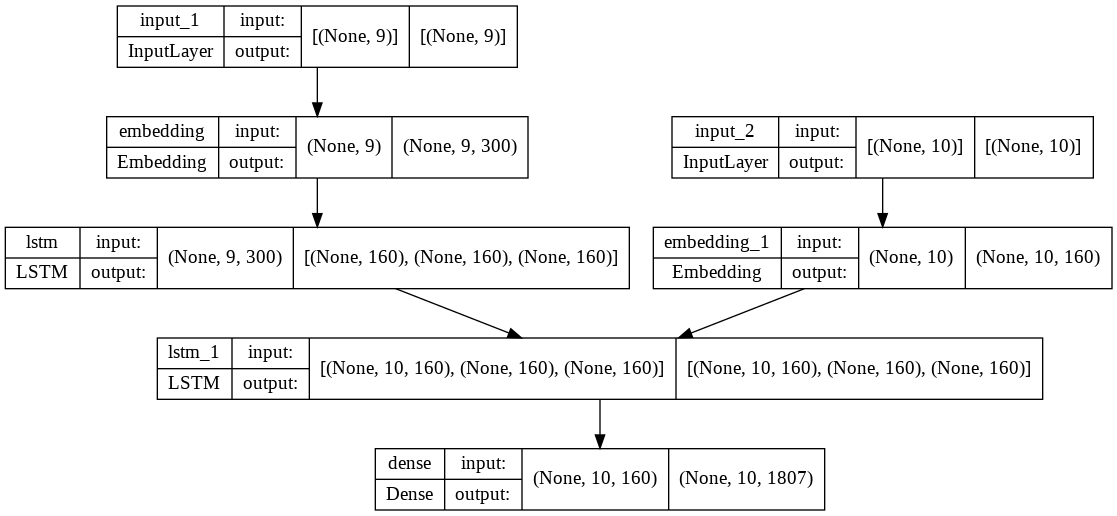

In [19]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

#### Definimos el modelo solo encoder y lo ploteamos

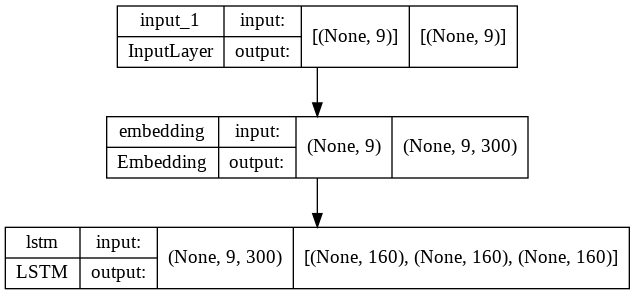

In [20]:
encoder_model = Model(encoder_inputs, encoder_states)

plot_model(encoder_model, to_file='encoder_plot.png', show_shapes=True, show_layer_names=True)

#### Definimos el modelo decoder de inferencia y lo ploteamos

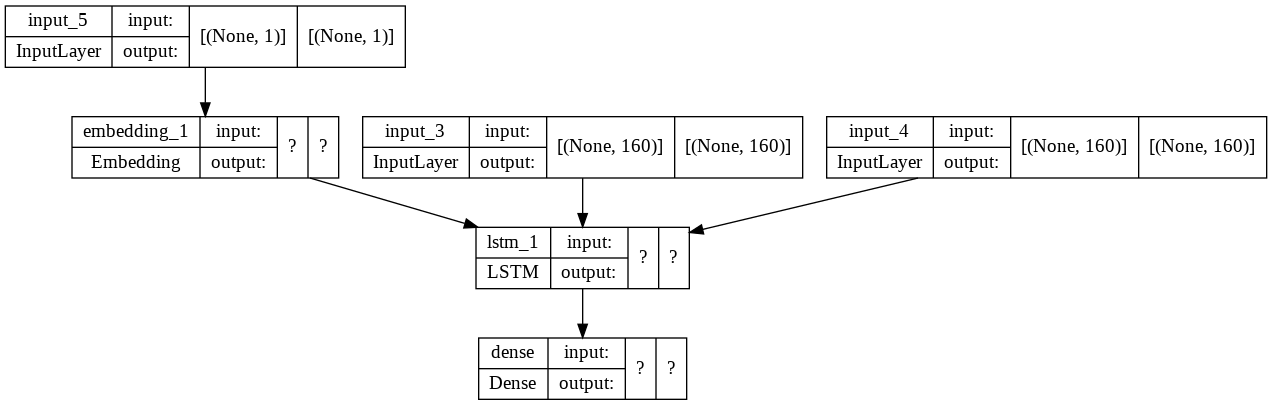

In [21]:
decoder_state_input_h = Input(shape=(n_units,))
decoder_state_input_c = Input(shape=(n_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding_layer(decoder_inputs_single)

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs_single] + decoder_states_inputs, [decoder_outputs] + decoder_states)

plot_model(decoder_model, to_file='decoder_plot.png', show_shapes=True, show_layer_names=True)

#### Hacemos el fit de nuestro modelo

In [22]:
CANT_EPOCHS = 60

In [23]:
hist = model.fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_targets,
    epochs=CANT_EPOCHS, 
    validation_split=0.2)

Epoch 1/60
151/151 [==============================] - 12s 18ms/step - loss: 2.9236 - accuracy: 0.5410 - val_loss: 2.2216 - val_accuracy: 0.6321
Epoch 2/60
151/151 [==============================] - 2s 11ms/step - loss: 1.9953 - accuracy: 0.6378 - val_loss: 2.0162 - val_accuracy: 0.6701
Epoch 3/60
151/151 [==============================] - 2s 11ms/step - loss: 1.7264 - accuracy: 0.6967 - val_loss: 1.8701 - val_accuracy: 0.6957
Epoch 4/60
151/151 [==============================] - 2s 14ms/step - loss: 1.5693 - accuracy: 0.7196 - val_loss: 1.7948 - val_accuracy: 0.7027
Epoch 5/60
151/151 [==============================] - 2s 15ms/step - loss: 1.4721 - accuracy: 0.7304 - val_loss: 1.7423 - val_accuracy: 0.7082
Epoch 6/60
151/151 [==============================] - 2s 13ms/step - loss: 1.4052 - accuracy: 0.7387 - val_loss: 1.7141 - val_accuracy: 0.7135
Epoch 7/60
151/151 [==============================] - 2s 13ms/step - loss: 1.3518 - accuracy: 0.7435 - val_loss: 1.6936 - val_accuracy: 0.715

#### Ploteamos las metricas del entrenamiento

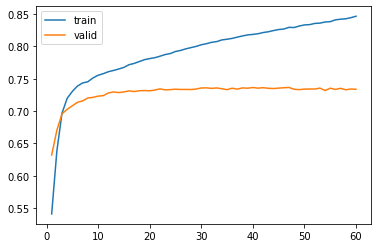

In [24]:
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

### 5 - Inferencia
Experimentar el funcionamiento de su modelo. Recuerde que debe realizar la inferencia de los modelos por separado de encoder y decoder.

#### Armamos lo conversores de indice a palabra:

In [25]:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

#### Definimos nuestra funcion de respuesta

In [26]:
def answer_question(input_seq):
    # Se transforma la sequencia de entrada a los stados "h" y "c" de la LSTM
    # para enviar la primera vez al decoder"
    states_value = encoder_model.predict(input_seq)

    # Se inicializa la secuencia de entrada al decoder como "<sos>"
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs["<sos>"]

    # Se obtiene el indice que finaliza la inferencia
    eos = word2idx_outputs["<eos>"]
    
    output_sentence = []
    for _ in range(max_out_len):
        # Predicción del próximo elemento
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])

        # Si es "end of sentece <eos>" se acaba
        if eos == idx:
            break

        # Transformar ídx a palabra
        word = ''        
        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        # Actualizar los estados dado la ultimo prediccion
        states_value = [h, c]

        # Actualizar secuencia de entrada con la salida (re-alimentacion)
        target_seq[0, 0] = idx

    return ' '.join(output_sentence)

#### Generamos algunas consultas para ver el comportamiento del bot

In [27]:
for t in range(5):
  i = np.random.choice(len(input_sentences))
  input_seq = encoder_input_sequences[i:i+1]
  translation = answer_question(input_seq)
  print('-')
  print('Input:', input_sentences[i])
  print('Response:', translation)

-
Input: do you 
Response: what do you do for a living
-
Input: oh really how old are they 
Response: no
-
Input: i think you actually have 
Response: i love to go to the beach
-
Input: what kind of dog breed is he 
Response: i do not have any
-
Input: talk to you later 
Response: i like to go to the beach


#### Generamos una conversacion con varias preguntas hechas por nosotros

In [28]:
frase_analizar = input('Frase usuario: ')
while frase_analizar !='':
  frase_tokenizada = input_tokenizer.texts_to_sequences([frase_analizar])[0]
  frase_encodeada = pad_sequences([frase_tokenizada], maxlen=max_input_len)
  respuesta_bot = answer_question(frase_encodeada)
  print('Respuesta bot : ',respuesta_bot)
  frase_analizar = input('Frase usuario: ')

Frase usuario: Hello. What's your name?
Respuesta bot :  my name is lucy
Frase usuario: How old are you?
Respuesta bot :  i am 32 i am 32
Frase usuario: Are you human?
Respuesta bot :  i am not sure what you mean
Frase usuario: Are you a bot?
Respuesta bot :  i am a girl i am a girl
Frase usuario: Are you an IA?
Respuesta bot :  no i am not sure
Frase usuario: Are you intelligent?
Respuesta bot :  no
Frase usuario: Do you like music?
Respuesta bot :  i like to go to the beach
Frase usuario: How many times have you gone to the beach?
Respuesta bot :  i am a student
Frase usuario: Can you help me?
Respuesta bot :  i am a student
Frase usuario: What do you study?
Respuesta bot :  i am a student
Frase usuario: Do like to study?
Respuesta bot :  i like to go to the beach
Frase usuario: Whtat's the weather like?
Respuesta bot :  what do you do for a living
Frase usuario: I work. What do you do for a living?
Respuesta bot :  i am a student
Frase usuario: Do you read?
Respuesta bot :  i am a g

### Conclusiones

* Se pude implementar un bot que responde varias de nuestras preguntas con coherencia
* Se pudo utilizar fasttex como embeddings pre-entrenados
* Con una arquitectura formada por 160 neuronas se obtuvo un tiempo de entrenamiento de 2 minutos y medio y se lograron resultados aceptables